## Preprocesamiento de los datos

In [1]:
import re
import json
import ast
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
import numpy as np
import pandas as pd

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

df_train = pd.read_csv('data/train.csv')

def convertir_a_lista(texto):
    try:
        # Attempt to parse the string as JSON
        return json.loads(texto)
    except json.JSONDecodeError:
        # If it fails, return the text wrapped in a list
        return [texto]  # Wrap the text as a list to maintain consistency

STOP_WORDS = set(stopwords.words('english'))

extra_stopwords = {'use', 'used', 'data', 'help', 'need', 'time', 'may', 'one', 'would', 'could', 'like', 'also', 'using', 'make', 'please', 'i', 'write'}

# Combine NLTK stopwords with the additional unwanted words
STOPWORDS = STOP_WORDS.union(extra_stopwords)

def limpiar_texto(texto: str) -> str:
    if not texto:
        return ""

    # Vectorized operations for text cleaning
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+|https\S+|[#@']", "", texto, flags=re.MULTILINE)  # Remove URLs, hashtags, etc.
    texto = texto.encode('ascii', 'ignore').decode('ascii')  # Remove non-ASCII
    texto = texto.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    # Tokenization and stopword removal using the precomputed stopwords
    tokens = [word for word in word_tokenize(texto) if word not in STOP_WORDS]

    texto_limpio = ' '.join(tokens)
    return texto_limpio

def procesar_respuesta(responses: pd.Series) -> pd.Series:
    # Convert LaTeX to text and then clean the list without apply
    responses = responses.str.replace(r'\\(begin|end)\{itemize\}', '', regex=True)\
                         .str.replace(r'\\item\s*', '\n', regex=True)\
                         .str.replace(r'\\[a-zA-Z]+\{[^}]*\}', '', regex=True)\
                         .str.replace(r'\s+', ' ', regex=True).str.strip()

    # Convert JSON strings to lists with error handling
    responses = responses.map(convertir_a_lista)

    # Clean the text inside the lists using numpy's vectorize to avoid apply
    responses = responses.map(lambda lista: np.vectorize(limpiar_texto)(lista) if isinstance(lista, list) else lista)

    return responses

def limpiar_df(df: pd.DataFrame) -> pd.DataFrame:
    # Vectorized operations for cleaning prompts and responses
    df['prompt'] = df['prompt'].apply(ast.literal_eval)
    df['prompt_limpio'] = df['prompt'].apply(lambda lista: [limpiar_texto(texto) for texto in lista])

    # Convert LaTeX to text and clean responses directly
    df['response_a_limpio'] = procesar_respuesta(df['response_a'])
    df['response_b_limpio'] = procesar_respuesta(df['response_b'])

    return df

df_train = limpiar_df(df_train)

import matplotlib.pyplot as plt
# Enable inline plotting
%matplotlib inline
# Cruce de preferencias con los modelos
cross_a = pd.crosstab(df_train['model_a'], df_train['winner_model_a'])
cross_b = pd.crosstab(df_train['model_b'], df_train['winner_model_b'])
# Concatenar los modelos A y B para evitar duplicados en los empates
all_models_tie = pd.concat([df_train[['model_a', 'winner_tie']],
                            df_train[['model_b', 'winner_tie']].rename(columns={'model_b': 'model_a'})])

# Contar los empates por modelo
tie_counts = all_models_tie[all_models_tie['winner_tie'] == 1]['model_a'].value_counts()

a_winners = df_train[['model_a', 'winner_model_a', 'winner_model_b', 'winner_tie']]
b_winners = df_train[['model_b', 'winner_model_a', 'winner_model_b', 'winner_tie']]

a_winners.rename(columns={'model_a': 'model', 'winner_model_a': 'win', 'winner_model_b': 'loss', 'winner_tie': 'tie'}, inplace=True)
b_winners.rename(columns={'model_b': 'model', 'winner_model_a': 'loss', 'winner_model_b': 'win', 'winner_tie': 'tie'}, inplace=True)

winners_df = pd.concat([a_winners, b_winners], ignore_index=True)

model_occurrences = winners_df['model'].value_counts()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-1-eee1fa8859ea>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_winners.rename(columns={'model_a': 'model', 'winner_model_a': 'win', 'winner_model_b': 'loss', 'winner_tie': 'tie'}, inplace=True)
<ipython-input-1-eee1fa8859ea>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [2]:
import re
import json
import ast
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load data
df_train = pd.read_csv('data/train.csv')

# Function to safely convert JSON-like strings to lists
def convertir_a_lista(texto):
    if isinstance(texto, str):
        texto = texto.replace(r'\/', '/')
        try:
            return json.loads(texto)
        except json.JSONDecodeError:
            return [texto]
    elif isinstance(texto, (int, float)):
        return [str(texto)]
    elif isinstance(texto, list):
        return texto
    else:
        return [texto]

# Preprocess columns with potential JSON-like strings
df_train['prompt'] = df_train['prompt'].map(convertir_a_lista)
df_train['response_a'] = df_train['response_a'].map(convertir_a_lista)
df_train['response_b'] = df_train['response_b'].map(convertir_a_lista)

# Define stopwords
STOP_WORDS = set(stopwords.words('english'))
extra_stopwords = {'use', 'used', 'data', 'help', 'need', 'time', 'may', 'one', 'would', 'could', 'like', 'also', 'using', 'make', 'please', 'i', 'write'}
STOPWORDS = STOP_WORDS.union(extra_stopwords)

# Clean text function
def limpiar_texto(texto) -> str:
    # Convert any non-string input to a string
    if not isinstance(texto, str):
        texto = str(texto)

    # Lowercase and clean the text
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+|https\S+|[#@']", "", texto, flags=re.MULTILINE)  # Remove URLs, hashtags, etc.
    texto = texto.encode('ascii', 'ignore').decode('ascii')  # Remove non-ASCII characters
    texto = texto.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    # Tokenization and stopword removal
    tokens = [word for word in word_tokenize(texto) if word not in STOPWORDS]
    return ' '.join(tokens)

# Process response columns, converting LaTeX and JSON strings to clean lists
def procesar_respuesta(responses: pd.Series) -> pd.Series:
    # Clean the text by removing LaTeX markers and extra whitespace
    responses = responses.str.replace(r'\\(begin|end)\{itemize\}', '', regex=True)\
                         .str.replace(r'\\item\s*', '\n', regex=True)\
                         .str.replace(r'\\[a-zA-Z]+\{[^}]*\}', '', regex=True)\
                         .str.replace(r'\s+', ' ', regex=True).str.strip()

    # Convert JSON strings to lists
    responses = responses.map(convertir_a_lista)

    # Apply `limpiar_texto` to each item in the list if the list is not empty
    responses = responses.map(lambda lista: np.vectorize(limpiar_texto)(lista) if isinstance(lista, list) and len(lista) > 0 else lista)

    return responses


# Flatten prompts and responses into individual rows
def flatten_prompts(df: pd.DataFrame) -> pd.DataFrame:
    flattened_data = []

    for _, row in df.iterrows():
        prompts = row['prompt']
        responses_a = row['response_a']
        responses_b = row['response_b']

        num_entries = min(len(prompts), len(responses_a), len(responses_b))

        for i in range(num_entries):
            flattened_data.append({

                'model_a': row['model_a'],
                'model_b': row['model_b'],
                'prompt': prompts[i],
                'response_a': responses_a[i],
                'response_b': responses_b[i],
                'winner_model_a': row['winner_model_a'],
                'winner_model_b': row['winner_model_b'],
                'winner_tie': row['winner_tie']
            })

    return pd.DataFrame(flattened_data)

# Apply flattening function
df_train = flatten_prompts(df_train)

# Clean flattened DataFrame
def limpiar_df(df: pd.DataFrame) -> pd.DataFrame:
    df['prompt'] = df['prompt'].apply(limpiar_texto)
    df['response_a'] = procesar_respuesta(df['response_a'])
    df['response_b'] = procesar_respuesta(df['response_b'])
    return df

df_train = limpiar_df(df_train)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df_train.head()

,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,gpt-4-1106-preview,gpt-4-0613,morally right try certain percentage females m...,[question whether morally right aim certain pe...,[ai dont personal beliefs opinions however tel...,1,0,0
1,gpt-4-1106-preview,gpt-4-0613,ok pineapple belong pizza relax give fun answer,[ah ageold culinary conundrum divided nations ...,[ai dont eat dont personal preferences world p...,1,0,0
2,koala-13b,gpt-4-0613,difference marriage license marriage certificate,[marriage license legal document allows couple...,[marriage license marriage certificate two dif...,0,1,0
3,koala-13b,gpt-4-0613,get quick possible california,[want get marriage license marriage certificat...,[california general steps obtain marriage lice...,0,1,0
4,koala-13b,gpt-4-0613,minimal get 1 day 10 days,[minimal get marriage license marriage certifi...,[marriage license california issued immediatel...,0,1,0


In [4]:
# Ensure required packages are installed
#%pip install tensorflow
#%pip install keras
#%pip install keras_nlp
%pip install vaderSentiment

## Construcción del modelo

In [7]:
import tensorflow as tf
from tensorflow import keras
from transformers import DistilBertTokenizer, TFDistilBertModel
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
import numpy as np

# Initialize tokenizer, model, and sentiment analyzer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
analyzer = SentimentIntensityAnalyzer()

# Function to create target labels
def create_target(df):
    conditions = [
        (df["winner_model_a"] == 1),
        (df["winner_model_b"] == 1),
        (df["winner_tie"] == 1)
    ]
    choices = [0, 1, 2]  # 0: Model A, 1: Model B, 2: Tie
    df["target"] = np.select(conditions, choices, default=-1)
    return df

df_train = create_target(df_train)
X = df_train[['prompt', 'response_a', 'response_b']]
y = df_train['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=3)

# Batch preprocessing function
def preprocess_batch(prompts, responses):
    texts = [f"{prompt} {response}" for prompt, response in zip(prompts, responses)]

    # Batch sentiment analysis
    sentiments = [analyzer.polarity_scores(text)["compound"] for text in texts]

    # Tokenize texts in batches
    tokens = tokenizer(texts, padding="max_length", max_length=28, truncation=True, return_tensors="tf")
    distilbert_output = distilbert_model(input_ids=tokens["input_ids"], attention_mask=tokens["attention_mask"])

    # Use the [CLS] token embedding for classification
    cls_embeddings = distilbert_output.last_hidden_state[:, 0, :]

    # Add sentiment scores to embeddings
    sentiment_tensor = tf.convert_to_tensor(sentiments, dtype=tf.float32)
    sentiment_tensor = tf.expand_dims(sentiment_tensor, axis=-1)
    combined_embeddings = tf.concat([cls_embeddings, sentiment_tensor], axis=-1)

    return combined_embeddings

# Prepare model inputs
def prepare_model_input(df):
    # Process in chunks
    batch_size = 16
    embeddings = []
    for start in range(0, len(df), batch_size):
        end = min(start + batch_size, len(df))
        prompt_batch = df["prompt"].iloc[start:end].tolist()
        response_a_batch = df["response_a"].iloc[start:end].tolist()
        response_b_batch = df["response_b"].iloc[start:end].tolist()

        # Get embeddings for response A and B
        embeddings_a = preprocess_batch(prompt_batch, response_a_batch)
        embeddings_b = preprocess_batch(prompt_batch, response_b_batch)

        # Concatenate embeddings of both responses
        combined = tf.concat([embeddings_a, embeddings_b], axis=-1)
        embeddings.append(combined)

    return tf.concat(embeddings, axis=0)

train_inputs = prepare_model_input(X_train)
test_inputs = prepare_model_input(X_test)

# Build classifier
inputs = keras.Input(shape=(train_inputs.shape[-1],), name="input_embeddings")
dense_layer = keras.layers.Dense(24, activation="relu")(inputs)
output = keras.layers.Dense(3, activation="softmax", name="classifier")(dense_layer)

model = keras.Model(inputs=inputs, outputs=output)
model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")]
)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy")
]

# Train model
model.fit(
    train_inputs,
    y_train_cat,
    validation_data=(test_inputs, y_test_cat),
    batch_size=8,
    epochs=10,
    callbacks=callbacks
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBert

Epoch 1/10
5364/5364 [==============================] - 19s 3ms/step - loss: 1.0994 - accuracy: 0.3491 - val_loss: 1.0974 - val_accuracy: 0.3505
Epoch 2/10
  28/5364 [..............................] - ETA: 10s - loss: 1.1004 - accuracy: 0.3527

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5364/5364 [==============================] - 17s 3ms/step - loss: 1.0982 - accuracy: 0.3473 - val_loss: 1.0970 - val_accuracy: 0.3503
Epoch 3/10
5364/5364 [==============================] - 18s 3ms/step - loss: 1.0982 - accuracy: 0.3469 - val_loss: 1.0972 - val_accuracy: 0.3503
Epoch 4/10
5364/5364 [==============================] - 17s 3ms/step - loss: 1.0982 - accuracy: 0.3482 - val_loss: 1.0980 - val_accuracy: 0.3503


894/894 [==============================] - 2s 3ms/step


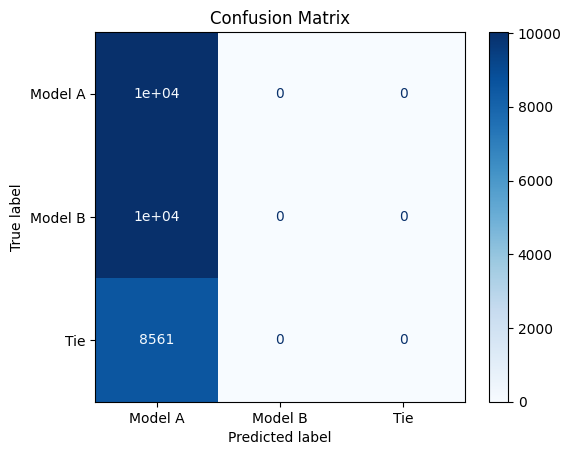

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Make predictions on the test set
y_pred = model.predict(test_inputs)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_test_classes = np.argmax(y_test_cat, axis=1)  # Convert one-hot encoded test labels back to class labels

# Step 2: Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Step 3: Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Model A", "Model B", "Tie"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
